In [65]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import time

from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import cohen_kappa_score

In [66]:
def unzip_dataset(INPATH, OUTPATH):
    with zipfile.ZipFile(INPATH) as zf:
        zf.extractall(OUTPATH)
    
unzip_dataset(INPATH = './train_data.zip', OUTPATH = './')
unzip_dataset(INPATH = './test_data.zip', OUTPATH = './')

In [67]:
train_dir = '../Casting_products_pytorch/train_data/'
test_dir = '../Casting_products_pytorch/test_data/'
train_df = pd.read_csv('../Casting_products_pytorch/train.csv')

In [68]:
train_df, val_df = train_test_split(np.array(train_df), test_size=0.1)

In [69]:
transform = torchvision.transforms.ToTensor()

In [70]:
class Casting_products_Datasets(Dataset):
    def __init__(self, dir_name, csv_file, transform=None):
        self.dir_name = dir_name
        self.csv_file = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, index):
        file = self.csv_file[index][0]
        label = np.array([self.csv_file[index][1]], np.float32)
        image = Image.open(self.dir_name + file)
        image = self.transform(image)

        return image, label

In [71]:
train_dataset = Casting_products_Datasets(train_dir, train_df, transform)
val_dataset = Casting_products_Datasets(train_dir, val_df, transform)

In [72]:
batch_size = 25

In [73]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [74]:
class EarlyStopping:

    def __init__(self, patience=5, verbose=False, path='../Casting_products_pytorch/checkpoint_model.pth'):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.path = path
    
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'   EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.checkpoint(val_loss, model)
            self.counter = 0
    
    def checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'   Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
                

In [75]:
class Network(nn.Module):
    def __init__(self):
        
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=12)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=24)
        self.fc1 = nn.Linear(24*71*71, 128)
        self.fc2 = nn.Linear(128, 48)
        self.fc3 = nn.Linear(48, 1)
    
    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.view(-1, 24*71*71)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x
    
model = Network()

In [76]:
lr = 1e-4
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr)

In [77]:
train_images, train_labels = iter(train_dataloader).next()
val_images, val_labels = iter(val_dataloader).next()

In [78]:
earlystopping = EarlyStopping(patience=5, verbose=True)

In [79]:
def train(train_dataloader):

    model.train()
    running_loss = 0
    
    for train_images, train_labels in train_dataloader:
        optimizer.zero_grad()
        y_preds = model(train_images)
        loss = criterion(y_preds, train_labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss / len(train_dataloader)
    
    return train_loss

def val(val_dataloader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            y_preds = model(val_images)
            loss = criterion(y_preds, val_labels)
            running_loss += loss.item()
            result = torch.round(y_preds)
            correct += torch.sum(result == val_labels) * 1.0
            total += val_labels.size(0)
    val_loss = running_loss / len(val_dataloader)
    val_acc = correct / total

    return val_loss, val_acc

In [80]:
record_loss_train = []
record_loss_val = []
record_acc_val =[]
num_epochs = 50

In [81]:
for epoch in range(num_epochs):
    loss= train(train_dataloader)
    val_loss, val_acc = val(val_dataloader)
    print('epoch %d, loss: %.4f ...  val_loss: %.4f ...  val_acc: %.4f ...' % (epoch, loss, val_loss, val_acc))
    
    record_loss_train.append(loss)
    record_loss_val.append(val_loss)
    record_acc_val.append(val_acc)

    earlystopping(val_loss, model)
    if earlystopping.early_stop:
        print("Early Stopping!")
        break

epoch 0, loss: 0.6810 ...  val_loss: 0.6631 ...  val_acc: 0.6000 ...
   Validation loss decreased (inf --> 0.663073). Saving model ...
epoch 1, loss: 0.3646 ...  val_loss: 0.8802 ...  val_acc: 0.6000 ...
   EarlyStopping counter: 1 out of 5
epoch 2, loss: 0.2570 ...  val_loss: 1.1976 ...  val_acc: 0.6000 ...
   EarlyStopping counter: 2 out of 5
epoch 3, loss: 0.1964 ...  val_loss: 1.1933 ...  val_acc: 0.6000 ...
   EarlyStopping counter: 3 out of 5
epoch 4, loss: 0.1155 ...  val_loss: 0.9377 ...  val_acc: 0.6000 ...
   EarlyStopping counter: 4 out of 5
epoch 5, loss: 0.0764 ...  val_loss: 0.3472 ...  val_acc: 0.7600 ...
   Validation loss decreased (0.663073 --> 0.347209). Saving model ...
epoch 6, loss: 0.0488 ...  val_loss: 0.4514 ...  val_acc: 0.8000 ...
   EarlyStopping counter: 1 out of 5
epoch 7, loss: 0.0454 ...  val_loss: 0.1690 ...  val_acc: 0.9200 ...
   Validation loss decreased (0.347209 --> 0.169010). Saving model ...
epoch 8, loss: 0.0315 ...  val_loss: 0.1486 ...  val_ac

In [82]:
model.load_state_dict(torch.load('../Casting_products_pytorch/checkpoint_model.pth'))

<All keys matched successfully>

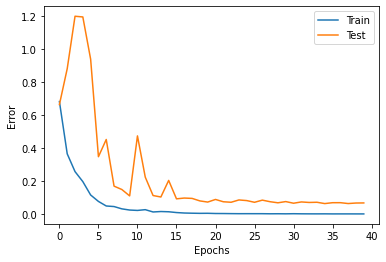

In [83]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_val)), record_loss_val, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [95]:
test_df = pd.read_csv('sample_submission.csv', header=None, names=['id', 'target'])
test_df2 = np.array(test_df)

In [96]:
class test_Datasets(Dataset):
    def __init__(self, dir_name, csv_file, transform=None):
        self.dir_name = dir_name
        self.csv_file = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, index):
        file = self.csv_file[index][0]
        image = Image.open(self.dir_name + file)
        image = self.transform(image)

        return image

In [97]:
test_dataset = test_Datasets(test_dir, test_df2, transform)

In [98]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [99]:
test_images = iter(test_dataloader).next()

In [100]:
pred = []

model.eval()
with torch.no_grad():
    for sample_submission_images in test_dataloader:
        pred.append(torch.round(model(sample_submission_images)).tolist())

In [107]:
pred = np.ravel(pred).astype(int)

In [109]:
test_df['target'] = pred

In [111]:
test_df.to_csv('sample_submission.csv', header = None, index = None)